# Hindi dataset

In [32]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [33]:
emotion_hindi_df = pd.read_csv('/content/Emotion_attached_final_hindi.csv')
emotion_hindi_df.head()

,Text_description,emotion_label
0,परधनमतर नरदर मद अमरक रषटरपत ज बइडन क बच पछल दन...,positive
1,मर पत चहत थ क म हमश तयर सज सवर रह म मथ बड बद ल...,positive
2,गजरत म लगतर ह रह भर बरश क करण जल म बढ क सथत बन...,positive
3,अवन लखर परस परलपक म महलओ क मटर एयर रइफल सटडग स...,anger
4,परस परलपक खल क शरआत अगसत स ह चक ह ओपनग सरमन म ...,negative


In [34]:
emotion_hindi_df.shape

(12037, 2)

In [35]:
emotion_hindi_df.isnull().sum()

,0
Text_description,0
emotion_label,0


In [36]:
texts = emotion_hindi_df['Text_description'].astype(str)
labels = emotion_hindi_df['emotion_label']

In [37]:
le = LabelEncoder()
labels_enc = le.fit_transform(labels)
num_classes = len(le.classes_)
print("Classes:", le.classes_, "| Num classes:", num_classes)

Classes: ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'negative' 'neutral'
 'positive' 'sadness' 'surprise' 'trust'] | Num classes: 11


In [38]:
# 3. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels_enc,
    test_size=0.2,
    random_state=42,
    stratify=labels_enc
)

In [39]:
# 4. Tokenize & pad
max_words = 10000
max_len   = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post', truncating='post')

In [40]:
# 5. Prepare labels for sparse loss
y_train = y_train.reshape(-1).astype('int32')
y_test  = y_test.reshape(-1).astype('int32')

In [41]:
# 6. Build the CNN model (with explicit input shape)
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_shape=(max_len,)),      # ← triggers shape inference
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
# 7. Compile
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [43]:
# 8. Inspect summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │           715 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,073,099 (4.09 MB)

 Trainable params: 1,073,099 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# 9. Train with EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=64,
    callbacks=[es]
)

Epoch 1/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.2864 - loss: 2.0307 - val_accuracy: 0.5286 - val_loss: 1.4382
Epoch 2/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.5482 - loss: 1.4689 - val_accuracy: 0.6272 - val_loss: 1.1728
Epoch 3/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.6160 - loss: 1.2564 - val_accuracy: 0.6469 - val_loss: 1.0686
Epoch 4/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.6707 - loss: 1.0635 - val_accuracy: 0.6874 - val_loss: 0.9998
Epoch 5/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.7299 - loss: 0.9269 - val_accuracy: 0.6999 - val_loss: 0.9658
Epoch 6/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.7698 - loss: 0.7852 - val_accuracy: 0.7061 - val_loss: 0.9605
Epoch 7/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.8081 - loss: 0.6691 - val_accuracy: 0.7165 - val_loss: 0.9865
Epoch 8/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8412 - loss: 0.5490 - val_

In [45]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7057 - loss: 1.0271
Test Accuracy: 0.7093


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


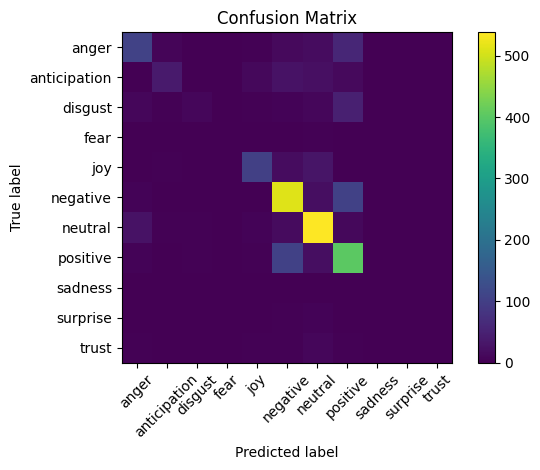

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Get model predictions (assuming model, X_test_pad, and y_test exist)
y_pred_prob = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# 2. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# 3. Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(le.classes_)), le.classes_, rotation=45)
plt.yticks(np.arange(len(le.classes_)), le.classes_)
plt.colorbar()
plt.tight_layout()
plt.show()


# Telugu Dataset


In [47]:
emotion_telugu_df = pd.read_csv('/content/Emotion_attached_final_telugu.csv')
emotion_telugu_df.head()

,cleaned_text,emotion_label
0,ట్రంప్‌ సుంకాల నేపథ్యంలో ఆర్థికమంత్రి నిర్మలా ...,neutral
1,"భారత మార్కెట్లు ట్రంప్‌ సుంకాల విరామం, వాణిజ్య...",neutral
2,ఎన్‌ఎస్ఈ ఐపీఓ అనుమతిలో వాణిజ్య ప్రయోజనాల కంటే ...,neutral
3,ఐటీసీ గ్రూప్‌ 24 మంత్ర ఆర్గానిక్‌ బ్రాండ్‌ను ర...,neutral
4,టాటా మోటార్స్‌ 2024-25 ఆర్థిక సంవత్సరంలో 250 ప...,neutral


In [48]:
emotion_telugu_df.shape

(10628, 2)

In [49]:
emotion_telugu_df.isnull().sum()

,0
cleaned_text,0
emotion_label,0


In [50]:
texts = emotion_telugu_df['cleaned_text'].astype(str)
labels = emotion_telugu_df['emotion_label']

In [51]:
le = LabelEncoder()
labels_enc = le.fit_transform(labels)
num_classes = len(le.classes_)
print("Classes:", le.classes_, "| Num classes:", num_classes)

Classes: ['anger' 'anticipation' 'disgust' 'fear' 'negative' 'neutral' 'positive'
 'trust'] | Num classes: 8


In [52]:
# 3. Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels_enc,
    test_size=0.2,
    random_state=42,
    stratify=labels_enc
)

In [53]:
# 4. Tokenize & pad
max_words = 10000
max_len   = 100

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post', truncating='post')

In [54]:
# 5. Prepare labels for sparse loss
y_train = y_train.reshape(-1).astype('int32')
y_test  = y_test.reshape(-1).astype('int32')

In [55]:
# 6. Build the CNN model (with explicit input shape)
embedding_dim = 100

model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_shape=(max_len,)),      # ← triggers shape inference
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
# 7. Compile
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [57]:
# 8. Inspect summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 96, 128)        │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,904 (4.09 MB)

 Trainable params: 1,072,904 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# 9. Train with EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[es]
)

Epoch 1/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.6051 - loss: 1.3031 - val_accuracy: 0.7591 - val_loss: 0.7708
Epoch 2/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.7649 - loss: 0.7776 - val_accuracy: 0.8096 - val_loss: 0.6137
Epoch 3/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.8459 - loss: 0.5307 - val_accuracy: 0.8331 - val_loss: 0.5142
Epoch 4/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.8792 - loss: 0.4251 - val_accuracy: 0.8543 - val_loss: 0.4993
Epoch 5/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9020 - loss: 0.3137 - val_accuracy: 0.8508 - val_loss: 0.5509
Epoch 6/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.9180 - loss: 0.2545 - val_accuracy: 0.8531 - val_loss: 0.5617
Epoch 7/20
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9404 - loss: 0.2105 - val_accuracy: 0.8684 - val_loss: 0.5860


In [59]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8341 - loss: 0.5293
Test Accuracy: 0.8467


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


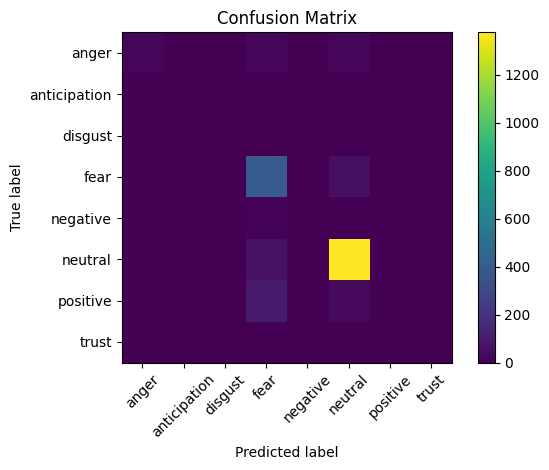

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Get model predictions (assuming model, X_test_pad, and y_test exist)
y_pred_prob = model.predict(X_test_pad)
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# 2. Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# 3. Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(len(le.classes_)), le.classes_, rotation=45)
plt.yticks(np.arange(len(le.classes_)), le.classes_)
plt.colorbar()
plt.tight_layout()
plt.show()

In [61]:
# Both CNN And LSTM

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step


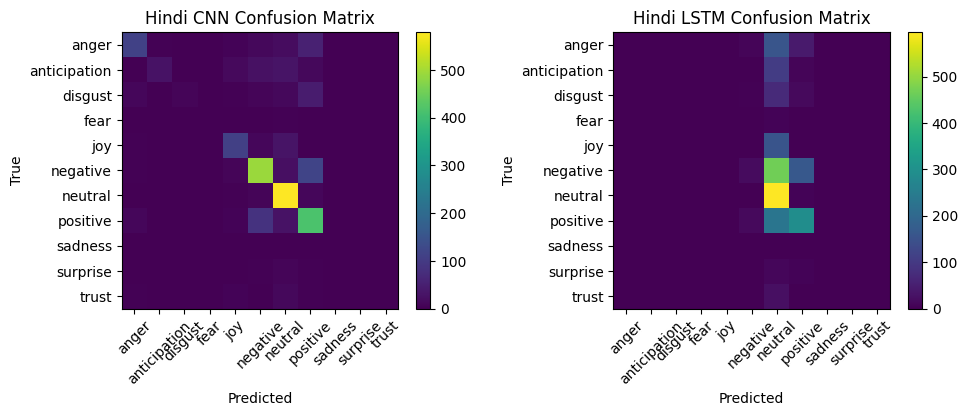

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step


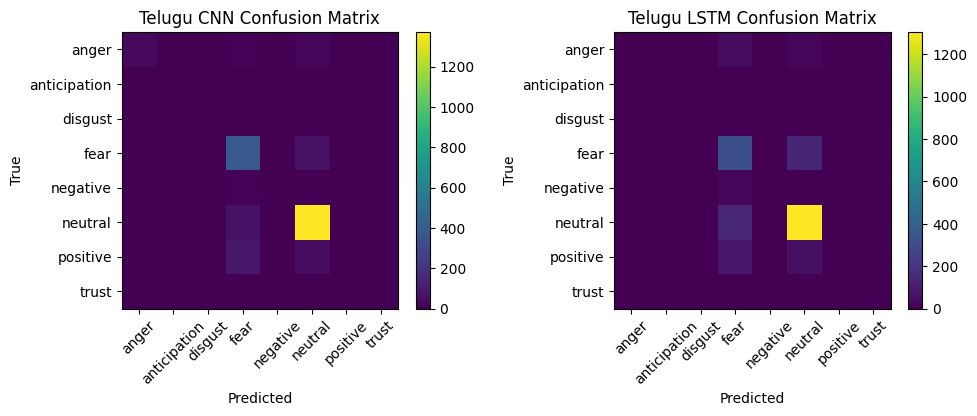

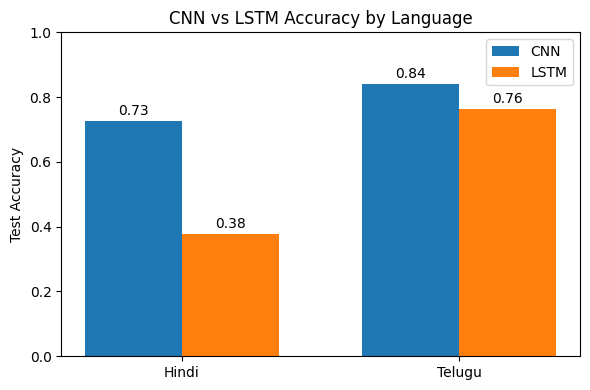

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Configuration for both languages
datasets = [
    ('Hindi', '/content/Emotion_attached_final_hindi.csv', 'Text_description'),
    ('Telugu', '/content/Emotion_attached_final_telugu.csv', 'cleaned_text'),
]

max_words = 10000
max_len = 100
embedding_dim = 100
batch_size = 64
epochs = 10

# Store results for comparison
results = {}

for lang, path, text_col in datasets:
    # 1. Load and preprocess
    df = pd.read_csv(path)
    texts = df[text_col].astype(str)
    labels = df['emotion_label']

    le = LabelEncoder()
    labels_enc = le.fit_transform(labels)
    num_classes = len(le.classes_)

    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels_enc,
        test_size=0.2,
        random_state=42,
        stratify=labels_enc
    )

    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)

    X_train_pad = pad_sequences(
        tokenizer.texts_to_sequences(X_train),
        maxlen=max_len, padding='post', truncating='post'
    )
    X_test_pad = pad_sequences(
        tokenizer.texts_to_sequences(X_test),
        maxlen=max_len, padding='post', truncating='post'
    )

    y_train = y_train.reshape(-1).astype('int32')
    y_test = y_test.reshape(-1).astype('int32')

    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # 2. Build & train CNN
    cnn = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=(max_len,)),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax'),
    ])
    cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    cnn.fit(X_train_pad, y_train, validation_split=0.1, epochs=epochs,
            batch_size=batch_size, callbacks=[es], verbose=0)
    loss_cnn, acc_cnn = cnn.evaluate(X_test_pad, y_test, verbose=0)
    y_pred_cnn = np.argmax(cnn.predict(X_test_pad), axis=1)
    cm_cnn = confusion_matrix(y_test, y_pred_cnn)

    # 3. Build & train LSTM
    lstm = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_shape=(max_len,)),
        LSTM(128),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax'),
    ])
    lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    lstm.fit(X_train_pad, y_train, validation_split=0.1, epochs=epochs,
             batch_size=batch_size, callbacks=[es], verbose=0)
    loss_lstm, acc_lstm = lstm.evaluate(X_test_pad, y_test, verbose=0)
    y_pred_lstm = np.argmax(lstm.predict(X_test_pad), axis=1)
    cm_lstm = confusion_matrix(y_test, y_pred_lstm)

    # Save results
    results[lang] = {
        'label_encoder': le,
        'accuracy': {'CNN': acc_cnn, 'LSTM': acc_lstm},
        'confusion_matrices': {'CNN': cm_cnn, 'LSTM': cm_lstm}
    }

    # 4. Plot confusion matrices for this language
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    for ax, cm, title in zip(
        axes,
        [cm_cnn, cm_lstm],
        [f'{lang} CNN Confusion Matrix', f'{lang} LSTM Confusion Matrix']
    ):
        im = ax.imshow(cm, interpolation='nearest')
        ax.set_title(title)
        ax.set_xticks(np.arange(num_classes))
        ax.set_xticklabels(le.classes_, rotation=45)
        ax.set_yticks(np.arange(num_classes))
        ax.set_yticklabels(le.classes_)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()

# 5. Compare accuracies across languages
fig, ax = plt.subplots(figsize=(6,4))
labels = list(results.keys())
cnn_acc = [results[l]['accuracy']['CNN'] for l in labels]
lstm_acc = [results[l]['accuracy']['LSTM'] for l in labels]

x = np.arange(len(labels))
width = 0.35

ax.bar(x - width/2, cnn_acc, width, label='CNN')
ax.bar(x + width/2, lstm_acc, width, label='LSTM')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel('Test Accuracy')
ax.set_title('CNN vs LSTM Accuracy by Language')
ax.legend()
for i in range(len(labels)):
    ax.text(x[i] - width/2, cnn_acc[i] + 0.02, f"{cnn_acc[i]:.2f}", ha='center')
    ax.text(x[i] + width/2, lstm_acc[i] + 0.02, f"{lstm_acc[i]:.2f}", ha='center')
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [63]:
accuracy_df = pd.DataFrame([
    {
        'Language': lang,
        'CNN Accuracy': results[lang]['accuracy']['CNN'],
        'LSTM Accuracy': results[lang]['accuracy']['LSTM']
    }
    for lang in results
])

In [64]:
accuracy_df

,Language,CNN Accuracy,LSTM Accuracy
0,Hindi,0.725498,0.376246
1,Telugu,0.840075,0.761994


In [ ]:
#
#
#
#
#
#
#
#
#
#
#
#         CNN, LSTM, MBERT, INDIC BERT CODE
#
#
#
#
#
#
#
#

In [69]:
!pip install torch torchvision torchaudio
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Configuration
datasets = {
    'Hindi': {
        'path': '/content/Emotion_attached_final_hindi.csv',
        'text_col': 'Text_description'
    },
    'Telugu': {
        'path': '/content/Emotion_attached_final_telugu.csv',
        'text_col': 'cleaned_text'
    }
}
max_len = 100
max_words = 10000
embedding_dim = 64
batch_size = 32
epochs = 3

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len)
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item
    def __len__(self):
        return len(self.labels)

def train_transformer(model_name, train_texts, train_labels, val_texts, val_labels, num_labels):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    train_ds = TextDataset(train_texts, train_labels, tokenizer)
    val_ds = TextDataset(val_texts, val_labels, tokenizer)
    args = TrainingArguments(
        output_dir='./tmp',
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        logging_dir='./logs',
        logging_steps=50,
        save_total_limit=1
    )
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
    )
    trainer.train()
    res = trainer.evaluate()
    return res['eval_accuracy']

results = {}

for lang, cfg in datasets.items():
    # Load data
    df = pd.read_csv(cfg['path'])
    texts = df[cfg['text_col']].astype(str).tolist()
    labels = df['emotion_label'].tolist()
    le = LabelEncoder()
    labels_enc = le.fit_transform(labels)
    num_classes = len(le.classes_)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels_enc, test_size=0.2, stratify=labels_enc, random_state=42
    )

    # Tokenize for Keras models
    tok = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tok.fit_on_texts(X_train)
    X_tr_seq = tok.texts_to_sequences(X_train)
    X_te_seq = tok.texts_to_sequences(X_test)
    X_tr = pad_sequences(X_tr_seq, maxlen=max_len, padding='post').astype('int32')
    X_te = pad_sequences(X_te_seq, maxlen=max_len, padding='post').astype('int32')
    y_tr = np.array(y_train, dtype='int32')
    y_te = np.array(y_test, dtype='int32')

    es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    # CNN model
    cnn = Sequential([
        Input(shape=(max_len,)),
        Embedding(input_dim=max_words, output_dim=embedding_dim),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn.fit(X_tr, y_tr, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)
    _, acc_cnn = cnn.evaluate(X_te, y_te, verbose=0)

    # LSTM model
    lstm = Sequential([
        Input(shape=(max_len,)),
        Embedding(input_dim=max_words, output_dim=embedding_dim),
        LSTM(64),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    lstm.fit(X_tr, y_tr, validation_split=0.1, epochs=epochs, batch_size=batch_size, callbacks=[es], verbose=0)
    _, acc_lstm = lstm.evaluate(X_te, y_te, verbose=0)

    # Transformer models
    acc_mbert = train_transformer('bert-base-multilingual-cased', X_train, y_train, X_test, y_test, num_classes)
    acc_ibert = train_transformer('ai4bharat/indic-bert', X_train, y_train, X_test, y_test, num_classes)

    results[lang] = {
        'CNN': acc_cnn,
        'LSTM': acc_lstm,
        'mBERT': acc_mbert,
        'IndicBERT': acc_ibert
    }

# Plot accuracies
df_acc = pd.DataFrame(results).T
df_acc.plot(kind='bar', figsize=(8,5))
plt.title('Model Accuracy Comparison by Language')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nayudammacnarne (nayudammacnarne-california-state-university-east-bay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,1.757100


Step,Training Loss
50,1.757100


In [ ]:
# wandb api: 13e80f9a0b070c054b6ad05fe35bebd99364eece